<a href="https://colab.research.google.com/github/coriander4all/exercicegan/blob/main/2_Exercise_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.15

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
  Using cached tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
!pip install comet_ml

## Imports

TODO: Signup for a free account at https://www.comet.ml and paste your API key below


In [3]:
# Import Comet package for tracking the experiments

from comet_ml import Experiment
### TODO: Signup for a free account at https://www.comet.ml and paste your API key below
exp = Experiment(
    api_key="WT6qlzLB67kzqU40wHG3vhkJG",
    project_name='applied-ai-gan-students')
### END OF TODO


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/coriandering/applied-ai-gan-students/fb2ea26eb11a4dccb216e26ccc7d7d6c



In [4]:
# Import models, layers, optmisers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Reshape, Conv2DTranspose, Conv2D, Flatten, LeakyReLU, ReLU,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
#other packages
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys
from skimage.transform import resize


COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


## Global variables

In [5]:
# Globals variables :
noise_input_shape = 100
batch_size = 128

## Utils functions (plotting, logging)
Take a look at TODOs ...


In [6]:
# Function to plot generated images :
'''
Arguments :
epoch - training epoch
generator - generator model from epoch epoch
exp - Comet.ml callback
examples - number of images to be plotted
dim - (rows, cols) of figure in which images will be plotted
figsize - size of the figure
prefix - prefix for the filename of the saved plot
'''
def plot_generated_images(epoch, generator, exp, examples=25, dim=(5, 5), figsize=(5, 5), prefix='dataset'):
    # TODO: Random input vector (shape=(num_examples,noise_input_shape))
    noise = tf.random.normal(shape=(examples, noise_input_shape))
    # TODO: Generate images from created noise vector
    generated_images = generator(noise)
    # Convert images into range [0-255] and convert to uint8 for proper plotting
    generated_images = ((generated_images * 127.5) + 127.5).astype('uint8')
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(np.squeeze(generated_images[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(prefix+'_gan_generated_image %d.png' % epoch)
    # Log plotted figure into Comet.ml
    exp.log_figure(figure_name='generated_images_ep'+str(epoch))
    plt.close()

# Function to plot real images :
'''
Arguments :
X_train - real dataset images (or batch of real dataset images)
exp - Comet.ml callback
examples - number of images to be plotted
dim - (rows, cols) of figure in which images will be plotted
figsize - size of the figure
prefix - prefix for the filename of the saved plot

'''
def plot_real_images(X_train, exp, examples=25, dim=(5, 5), figsize=(5, 5), prefix='dataset'):
    print(X_train.shape)
    real_images = X_train[:examples]
    print(real_images.shape)
    real_images = ((real_images.numpy() * 127.5) + 127.5).astype('uint8')
    print(real_images.shape)
    plt.figure(figsize=figsize)
    for i in range(real_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(np.squeeze(real_images[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(prefix+'_gan_real_image %d.png')
    # Log plotted figure into Comet.ml
    exp.log_figure(figure_name='real_images.png')
    plt.close()

# Comet logging gradinets distributions (vanishing gradients)
def get_gradients(gradmap, grads, model):
    for grad, param in zip(grads, model.trainable_variables):
        gradmap.setdefault(param.name, 0)
        gradmap[param.name] += grad

    return gradmap
def log_histogram(experiment, gradmap, step, prefix=None):
    for k, v in gradmap.items():
        experiment.log_histogram_3d(v, name="%s/%s" % (prefix, k), step=step)


##  Dataset

In [21]:
# Load dataset
dataset='mnist' #'cifar'
if dataset=='mnist':
  (x_train, y_train), (_, _) = mnist.load_data()
  out_channels = 1
  x_train = x_train[...,np.newaxis] #?
elif dataset=='cifar':
  (x_train, y_train), (_, _) = cifar10.load_data()
  out_channels = 3
else:
  sys.exit('Unknown dataset')

# Normalise data to the range (-1,1)
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

y_train = y_train.astype(np.int32)

# Training details
batch_count = x_train.shape[0] // batch_size # how many iteration per epoch


In [8]:
# If dataset is MNIST, we will resize the images to 32x32 size because 32 is more convenient being a power of 2.
# CIFAR images are already of size 32x32, resizing will change nothing
resize_shape = (32, 32, out_channels)

def parse_function(img):
    image = tf.image.resize(img,(resize_shape[0],resize_shape[1]))
    return image

In [30]:
# make trainig set
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(x_train.shape[0])
train_dataset = train_dataset.map(parse_function, num_parallel_calls=4)
train_dataset = train_dataset.batch(batch_size)

In [32]:
#for t in train_dataset:
#  print(t.shape)
#  break

(128, 32, 32, 1)


## **GAN model**


### Generator :

TODO - Generator transforms input noise to image. The input noise is reshaped to 3D tensor and upsampling is done via TransposeConvolution (take a look at https://keras.io/api/layers/convolution_layers/convolution2d_transpose/).

Complete the generator to have the following architecture:

<img src="https://seafile.unistra.fr/f/92b1617dc1724e39abd4/?dl=1"/>


*Input*: Noise (shape=(noise_input_shape,)).

*Output*: Image (32,32,1) for MNIST or (32,32,3) for CIFAR.



In [10]:
# TODO: Function to create generator
def create_generator(noise_input_shape=100,out_channels=3):
  # Input noise is a vector of length 100 (for example)
  input = Input(shape=(noise_input_shape,))
  filters = 256
  k_size = 4
  g = Reshape((1,1,noise_input_shape))(input)
  g = Conv2DTranspose(filters,(k_size,k_size),strides=1,kernel_initializer=initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.RandomNormal(stddev=0.02))(g)
  g = LeakyReLU(alpha=0.2)(g)

  ### TODO: complete the model (see https://keras.io/layers/convolutional/), all leakyReLu layers to have alpha=0.2, 4x4 convolution, and (2,2) stride
  # Upsampling blocks
  for i in range(1,4):
    f = filters//(2**i)
    # Spatial upsampling
    g = Conv2DTranspose(f, (4,4), strides=(2,2), padding="same", kernel_initializer=initializers.RandomNormal(stddev=0.02), bias_initializer=initializers.RandomNormal(stddev=0.02))(g)
    g = LeakyReLU(alpha=0.2)(g)

  # N.B. Number of channels (filters) in the last layer needs to be 1 for MNIST (output should be grayscale image),
  # or 3 for CIFAR (output should be an RGB image), with 3x3 convolution
  # Activation function in last layer should be tanh to match real images which are in the range [-1,1]
  g = Conv2D(out_channels, (3,3), padding="same", activation='tanh')(g)
  ### END OF TODO

  # Make the model
  model = Model(inputs=input, outputs=g)

  # Model doesn't need to be compiled because it will be trained in custom training
  # loop in combination with discriminator (new model will be created)
  return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         409856    
 anspose)                                                        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 128)         524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0     

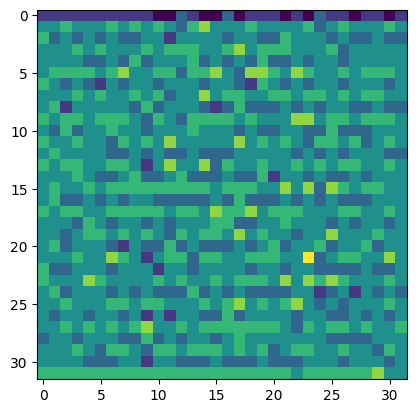

In [11]:
# Test generator
g = create_generator(out_channels=out_channels)
g.summary()
noise = tf.random.normal([1,noise_input_shape])
gen_img = g(noise,training=False).numpy()
plot_img = np.squeeze(gen_img)
plt.imshow(((plot_img * 127.5) + 127.5).astype('uint8'))

### Discriminator:

TODO - Discriminator distinguishing between real and fake samples:
It takes an image as an input and produce the probability of a given image being real.
This can be acheived  by using sigmoid activation function at the last layer. For computational stability, use **linear activation** in last layer (no activation) and **sigmoid will be added during loss calculation**.


Complete the discriminator to have the following architecture:

<img src="https://seafile.unistra.fr/f/2739577c4dde45cca672/?dl=1"/>


*Input*: Image (32,32,1) for MNIST or (32,32,3) for CIFAR.

*Output*: logit of binary classification (real or fake), shape=(1,))



In [12]:
# TODO: Function to create discriminator
def create_discriminator(input_shape):
    # Discriminator input has the same shape as the generator output
    input = Input(input_shape)
    filters = 64
    k_size= 3
    d = Conv2D(filters, (k_size, k_size),padding='same')(input)
    d = LeakyReLU(alpha=0.2)(d)

    ### TODO: complete the model - all convolutional layers to have a stride of (2,2), all leakyReLu layers to have alpha=0.2
    for i in range(1,4):
      f = filters*(2 ** i)
      d = Conv2D(f, (4,4), strides=(2,2), padding="same", kernel_initializer=initializers.RandomNormal(stddev=0.02), bias_initializer=initializers.RandomNormal(stddev=0.02))(d)
      d = LeakyReLU(alpha=0.2)(d)


    d = Flatten()(d)
    # Output is one number
    # Ideal output should be close to 1 for images from real dataset, close to 0 for generated images
    d = Dense(1)(d)
    ### END OF TODO

    model = Model(inputs = input,outputs=d)
    return model

In [13]:
# Test discriminator
d = create_discriminator(resize_shape)
d.summary()
decision = d(gen_img)
print(decision)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0   

tf.Tensor([[0.05882967]], shape=(1, 1), dtype=float32)


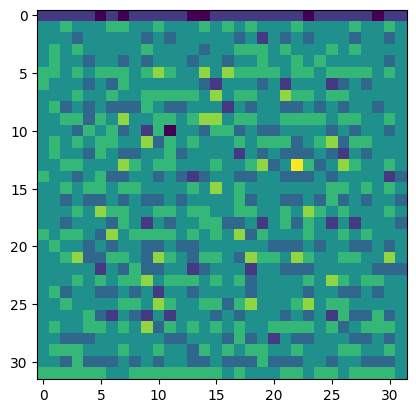

In [14]:
# Run this multiple times to see differences
noise = tf.random.normal([1,noise_input_shape])
gen_img = g(noise,training=False).numpy()
decision = d(gen_img)
print(decision)
plot_img = np.squeeze(gen_img)
plt.imshow(((plot_img* 127.5) + 127.5).astype('uint8'))

### Loss functions and optimisers


TODO

In [15]:
#TODO: Create binary cross entropy loss function (use parameter from_logits = True if activation is linear in disciminator).
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits = True)

#TODO: (hint: disciminator should predict one for real data)
def discriminator_loss_real_data(disc_pred_for_real_data):
    real_loss = loss_function(disc_pred_for_real_data, tf.ones(disc_pred_for_real_data.shape))
    return real_loss

#TODO: (hint: disciminator should  predict zero for real data)
def discriminator_loss_fake_data(disc_pred_for_generated_data):
    fake_loss = loss_function(disc_pred_for_generated_data, tf.zeros(disc_pred_for_generated_data.shape))
    return fake_loss

#TODO: (hint: generator wants that discriminator's predictions are close to one for generated data)
def generator_loss(disc_pred_for_generated_data):
    gen_loss =  loss_function(disc_pred_for_generated_data, tf.ones(disc_pred_for_generated_data.shape))
    return gen_loss

In [16]:
#Optimisers
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

# Prepare models

TODO

In [17]:
#TODO: Make models
generator = create_generator(out_channels=out_channels)
shape = generator.output_shape[1:]
discriminator = create_discriminator(resize_shape)

# Log and plot progress (Comet.ml)
exp.get_callback('keras').set_model(generator)

# GAN training

## Training step function

TODO

In [18]:
@tf.function
def train_step(real_images):
  ## Train discriminator
  #0. Make a noise vector
  noise = tf.random.normal([batch_size,noise_input_shape]) #tf.random.normal(real_images.shape)
  with tf.GradientTape() as disc_tape:
    # 1. generator generates an image from noise
    generated_images = generator(noise)
    # 2. discriminator prediction for real images
    real_output = discriminator(real_images)
    # 3. discriminator prediction for fake images
    fake_output = discriminator(generated_images)
    # 4. discriminator loss: (loss_on_real+loss_on_fake)/2
    disc_loss = (discriminator_loss_fake_data(fake_output)+discriminator_loss_real_data(real_output))/2

  #get discriminator's gradients
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  # Update the weights of the discriminator using the discriminator optimizer
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  ## Train generator
  #0. Make a noise vector
  noise = tf.random.normal([batch_size,noise_input_shape])
  with tf.GradientTape() as gen_tape:
      # 1. Generate fake images using the generator
      generated_images =  generator(noise)
      # 2. Get the discriminator prediction for fake images
      fake_output = discriminator(generated_images)
      # 3. Calculate the generator loss
      gen_loss = generator_loss(fake_output)

  #TODO: Update generator (see update discriminator)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


  return gen_loss, disc_loss, gradients_of_generator, gradients_of_discriminator

## Training loop

In [23]:

def train(dataset, epochs):
  real_plt = False
  cnt = 0
  gradmap_generator = {}
  gradmap_discriminator = {}

  for epoch in tqdm(range(epochs)):
    step=0
    for image_batch in dataset:
      #print("a")
      step = step+1
      if not real_plt:
         print("b")
         plot_real_images(image_batch, exp, prefix='real')
         real_plt = True

      print("c")
      gen_loss, disc_loss, gradients_of_generator, gradients_of_discriminator= train_step(image_batch)
      print("d")

      # Logs for comet
      gradmap_generator = get_gradients(gradmap_generator, gradients_of_generator, generator)
      gradmap_discriminator = get_gradients(gradmap_discriminator, gradients_of_discriminator, discriminator)

      exp.set_step(cnt)
      exp.log_metric("disc_loss",disc_loss,step=cnt)
      exp.log_metric("gen_loss", gen_loss, step=cnt)
      cnt = cnt+1
     # scale gradients
    for k, v in gradmap_generator.items():
      gradmap_generator[k] = v / step
    for k, v in gradmap_discriminator.items():
      gradmap_discriminator[k] = v / step

    plot_generated_images(epoch, generator, exp, prefix='cifar')
    log_histogram(exp, gradmap_generator,cnt, prefix="gradient_generator")
    log_histogram(exp, gradmap_discriminator,cnt, prefix="gradient_discriminator")


##Run code

In [ ]:
train(train_dataset, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

b
(128, 32, 32, 1)
(25, 32, 32, 1)
(25, 32, 32, 1)
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c
d
c


In [ ]:
exp.end()

# GAN playground

1. Try longer training
1. Train GAN with CIFAR dataset
1.  Change the learning rate of the Generator/Discriminator, try different optimisers
2.  Change Input noise shape
3.   Modify discriminator/generator architecture (adding BatchNormalisarion, deeper generator/discriminator)
4.   Increase the number of discriminator training iterations relative to the generator per epoch, e.g. discriminator is trained 2 times and generator 1 time per epoch
